## Import

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
import torch

In [63]:
# https://www.kaggle.com/datasets/benhamner/sf-bay-area-bike-share?select=status.csv
dataset_station_statut = pd.read_csv("../../../../Bike_Data/status.csv")
dataset_station = pd.read_csv("../../../../Bike_Data/station.csv")

## Class TimeSeriesDataset

In [64]:
# Define a PyTorch dataset to generate input/target pairs for the LSTM model
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size, stride, target_size=1, drop=None):
        self.data = data
        self.window_size = window_size
        self.stride = stride
        self.target_size = target_size
        self.drop = drop

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        inputs = self.data[idx:idx+self.window_size]
        target = self.data[idx+self.window_size:idx+self.window_size+self.target_size]
        if self.drop is not None:
            target = np.delete(target, self.drop, axis=1)
        return inputs, target

## Class GRU v1

In [65]:
class GRUNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRUNet, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = torch.nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

## Station statut dataset

## Station dataset

In [66]:
dataset_station.head(3)

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013


In [67]:
dataset_station.shape

(70, 7)

## Merge dataset Station statut and Station

In [68]:
dataset = pd.merge(dataset_station, dataset_station_statut, left_on='id', right_on='station_id')

In [69]:
dataset.head(3)

,id,name,lat,long,dock_count,city,installation_date,station_id,bikes_available,docks_available,time
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,2,2,25,2013/08/29 12:06:01
1,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,2,2,25,2013/08/29 12:07:01
2,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,2,2,25,2013/08/29 12:08:01


In [70]:
dataset.shape

(71984434, 11)

### See the mean variation for differents interval of time

In [71]:
dataset_station_statut_drop = dataset_station_statut.drop(["docks_available"], axis=1)
dataset_station_statut_drop['time'] = pd.to_datetime(dataset_station_statut_drop['time'], format="mixed")
pivoted_dataset_station_statut_drop = dataset_station_statut_drop.pivot_table(index='time', columns='station_id', values='bikes_available')

In [72]:
import pandas as pd

# assuming your dataframe is named df and has a datetime index
intervals = ['5min', '10min', '15min', '30min', '60min']
for interval in intervals:
    resampled = pivoted_dataset_station_statut_drop.resample(interval).var().mean().sort_values(ascending=False)
    print(f'Mean Variance for {interval} interval:')
    print(resampled)

Mean Variance for 5min interval:
station_id
70    0.227252
69    0.152443
50    0.144004
61    0.110123
60    0.104654
        ...   
33    0.006550
8     0.006083
23    0.005957
38    0.005068
5     0.004799
Length: 70, dtype: float64
Mean Variance for 10min interval:
station_id
70    0.500550
69    0.343188
50    0.317341
61    0.233667
60    0.210250
        ...   
8     0.011556
33    0.010267
5     0.008726
23    0.008316
38    0.007830
Length: 70, dtype: float64
Mean Variance for 15min interval:
station_id
70    0.783799
69    0.557002
50    0.492731
61    0.346430
65    0.325293
        ...   
8     0.016246
33    0.013776
5     0.012483
38    0.010602
23    0.010149
Length: 70, dtype: float64
Mean Variance for 30min interval:
station_id
70    1.463287
69    1.152336
50    1.010326
61    0.691692
65    0.667708
        ...   
5     0.024140
83    0.024065
33    0.023480
38    0.017727
23    0.014105
Length: 70, dtype: float64
Mean Variance for 60min interval:
station_id
70    2.

# 1/ (Univariate) Selection station to make prediction

### All id station available

In [73]:
print(dataset['id'].unique())
print(len(dataset['id'].unique()))

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 16 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 41 42 45 46 47 48 49 50 51 39 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 80 82 83 84]
70


In [74]:
dataset_station_id = dataset.loc[dataset['id'].isin([42])]

In [75]:
dock_count = dataset_station_id['dock_count'].unique()
print(dock_count)

[15]


In [76]:
dataset_station_id.shape

(1047141, 11)

In [77]:
dataset_station_id.head(3)

,id,name,lat,long,dock_count,city,installation_date,station_id,bikes_available,docks_available,time
34204912,42,Davis at Jackson,37.79728,-122.398436,15,San Francisco,8/19/2013,42,7,8,2013/08/29 12:06:01
34204913,42,Davis at Jackson,37.79728,-122.398436,15,San Francisco,8/19/2013,42,7,8,2013/08/29 12:07:01
34204914,42,Davis at Jackson,37.79728,-122.398436,15,San Francisco,8/19/2013,42,7,8,2013/08/29 12:08:01


In [78]:
dataset_station_id.tail(3)

,id,name,lat,long,dock_count,city,installation_date,station_id,bikes_available,docks_available,time
35252050,42,Davis at Jackson,37.79728,-122.398436,15,San Francisco,8/19/2013,42,3,12,2015-08-31 23:57:02
35252051,42,Davis at Jackson,37.79728,-122.398436,15,San Francisco,8/19/2013,42,3,12,2015-08-31 23:58:02
35252052,42,Davis at Jackson,37.79728,-122.398436,15,San Francisco,8/19/2013,42,3,12,2015-08-31 23:59:02


### Drop columns

In [79]:
dataset_station_id_drop = dataset_station_id.drop(["name", 'lat', 'long', 'id', 'city', 'installation_date', "docks_available", "dock_count"], axis=1)

In [80]:
dataset_station_id_drop.head(1)

,station_id,bikes_available,time
34204912,42,7,2013/08/29 12:06:01


### Check presence of null and NaN values

In [81]:
dataset_station_id_drop.isna().sum()

station_id         0
bikes_available    0
time               0
dtype: int64

In [82]:
dataset_station_id_drop[dataset_station_id_drop.isna().any(axis=1)]

,station_id,bikes_available,time


In [83]:
dataset_station_id_drop.dtypes

station_id          int64
bikes_available     int64
time               object
dtype: object

### Conversion column time to datetime

In [84]:
dataset_station_id_drop['time'] = pd.to_datetime(dataset_station_id_drop['time'], format="mixed")

In [85]:
dataset_station_id_drop.dtypes

station_id                  int64
bikes_available             int64
time               datetime64[ns]
dtype: object

In [86]:
dataset_station_id_drop.head(1)

,station_id,bikes_available,time
34204912,42,7,2013-08-29 12:06:01


In [87]:
dataset_station_id_drop.tail(1)

,station_id,bikes_available,time
35252052,42,3,2015-08-31 23:59:02


### Train

In [88]:
def plot_loss_valid(valid_losses):
    plt.plot(valid_losses, label = 'Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.show()

In [89]:
# Train your model and evaluate on the validation set
def train_model(model, optimizer, criterion, train_loader, valid_loader, num_epochs):
    num_epochs = num_epochs
    best_val_loss = float('inf')
    train_losses = []
    valid_losses = []
    for epoch in range(num_epochs):
        train_loss = 0.0

        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, targets.squeeze(dim=(1)).float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_losses.append(loss.item())
        val_loss = 0.0
    
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs.float())
            loss = criterion(outputs, targets.squeeze(dim=(1)).float())
            val_loss += loss.item()
        
        val_loss /= len(valid_loader)
        valid_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_GRU.pth')
    
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        
    plot_loss_valid(valid_losses)
    
    

### Test

In [90]:
def test_model(best_model, test_loader, criterion):
    # Load the best model and evaluate on the test set
    best_model.double()
    best_model.eval()

    # Evaluate the model on the test set
    test_loss = 0.0
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = best_model(inputs)
            loss = criterion(outputs, targets.squeeze(dim=(1)))
            test_loss += loss.item()
            # Save the predictions and actual values for plotting later
            predictions.append(outputs.cpu().numpy())
            actuals.append(targets.squeeze(dim=(1)).cpu().numpy())
    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")
    # Concatenate the predictions and actuals
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)

    return (predictions, actuals)

In [91]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

### Print Global Metrics 

In [92]:
def result_prediction(predictions, actuals):
    indices_by_month = []
    EPSILON = 1e-5
    # Créer une liste vide pour stocker les données du tableau
    data = []
    for i in range(1): 
        y_pred = predictions[:,i]
        y_true = actuals[:,i]

        signe = "-" if np.mean(y_pred - y_true) < 0 else "+"
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = mean_absolute_percentage_error(y_true, y_pred)*100
        if (mape > 1 or mape < 0):
            mape = "ERROR"
        smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))*100
        maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))*100

        # Ajouter une ligne au tableau avec le nom du mois et les metrics
        data.append(["Global", signe, mae, rmse, mape, smape, maape])

    # Créer un DataFrame avec les données du tableau et les noms des colonnes
    df = pd.DataFrame(data, columns=['Global', 'Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE'])
    # Définir le mois comme index du DataFrame
    df.set_index('Global', inplace=True)
    # Retourner le DataFrame
    return df

### Print Metrics for each month

In [93]:
def result_prediction_by_month(predictions, actuals):
    indices_by_month = []
    EPSILON = 1e-5
    # Créer une liste vide pour stocker les données du tableau
    data = []
    for i in range(1): 
        grouped_data = test_data.groupby(pd.Grouper(freq='M'))
        for name , group in grouped_data:
            indices = np.where(test_data.index.isin(group.index))[0]
            indices_by_month.append((name.strftime('%B'), indices))

        for name, indice in indices_by_month:
            y_pred = predictions[indice-window_size,i]
            y_true = actuals[indice-window_size,i]

            signe = "-" if np.mean(y_pred - y_true) < 0 else "+"
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mape = mean_absolute_percentage_error(y_true, y_pred)*100
            if (mape > 1 or mape < 0):
                mape = "ERROR"
            smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))*100
            maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))*100

            # Ajouter une ligne au tableau avec le nom du mois et les metrics
            data.append([name, signe, mae, rmse, mape, smape, maape])

    # Créer un DataFrame avec les données du tableau et les noms des colonnes
    df = pd.DataFrame(data, columns=['Month', 'Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE'])
    # Définir le mois comme index du DataFrame
    df.set_index('Month', inplace=True)
    # Retourner le DataFrame
    return df

### Print Metrics for each week

In [94]:
def result_prediction_by_week(predictions, actuals):
    indices_by_week = []
    EPSILON = 1e-5
    
    data = []
    for i in range(1): 
        grouped_data = test_data.groupby(pd.Grouper(freq='W'))
        for name , group in grouped_data:
            indices = np.where(test_data.index.isin(group.index))[0]
            indices_by_week.append((name.strftime('%W'), indices))

        for name, indice in indices_by_week:
            y_pred = predictions[indice-window_size,i]
            y_true = actuals[indice-window_size,i]

            signe = "-" if np.mean(y_pred - y_true) < 0 else "+"
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mape = mean_absolute_percentage_error(y_true, y_pred)*100
            if (mape > 1 or mape < 0):
                    mape = "ERROR"
            smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))*100
            maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))*100

            # Ajouter une ligne au tableau avec le nom du mois et les metrics
            data.append([name, signe, mae, rmse, mape, smape, maape])

    # Créer un DataFrame avec les données du tableau et les noms des colonnes
    df = pd.DataFrame(data, columns=['Week', 'Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE'])
    # Définir le mois comme index du DataFrame
    df.set_index('Week', inplace=True)
    # Retourner le DataFrame
    return df

### Print Metrics for each day

In [95]:
def result_prediction_by_day(predictions, actuals):
    indices_by_day = []
    EPSILON = 1e-5
    
    data = []
    for i in range(1): 
        grouped_data = test_data.groupby(pd.Grouper(freq='D'))
        for name , group in grouped_data:
            indices = np.where(test_data.index.isin(group.index))[0]
            indices_by_day.append((name.timetuple().tm_yday, indices))

        for name, indice in indices_by_day:
            y_pred = predictions[indice-window_size,i]
            y_true = actuals[indice-window_size,i]

            signe = "-" if np.mean(y_pred - y_true) < 0 else "+"
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mape = mean_absolute_percentage_error(y_true, y_pred)*100
            if (mape > 1 or mape < 0):
                mape = "ERROR"
            smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))*100
            maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))*100

            # Ajouter une ligne au tableau avec le nom du mois et les metrics
            data.append([name, signe, mae, rmse, mape, smape, maape])

    # Créer un DataFrame avec les données du tableau et les noms des colonnes
    df = pd.DataFrame(data, columns=['Day', 'Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE'])
    # Définir le mois comme index du DataFrame
    df.set_index('Day', inplace=True)
    # Retourner le DataFrame
    return df

### Print Metrics for each hour

In [96]:
def result_prediction_by_hour(predictions, actuals):
    indices_by_hour = []
    EPSILON = 1e-5
    
    data = []
    for i in range(1): 
        grouped_data = test_data.groupby(pd.Grouper(freq='H'))
        for name , group in grouped_data:
            indices = np.where(test_data.index.isin(group.index))[0]
            indices_by_hour.append((name, indices))

        for name, indice in indices_by_hour:
            y_pred = predictions[indice-window_size,i]
            y_true = actuals[indice-window_size,i]
            if len(y_pred) != 0 and len(y_true != 0) :
                signe = "-" if np.mean(y_pred - y_true) < 0 else "+"
                mae = mean_absolute_error(y_true, y_pred)
                rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                mape = mean_absolute_percentage_error(y_true, y_pred)*100
                if (mape > 1 or mape < 0):
                    mape = "ERROR"
                smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))*100
                maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))*100

                # Ajouter une ligne au tableau avec le nom du mois et les metrics
                data.append([f'{name.timetuple().tm_yday} / {name.hour}', signe, mae, rmse, mape, smape, maape])

    # Créer un DataFrame avec les données du tableau et les noms des colonnes
    df = pd.DataFrame(data, columns=['Day / Hour', 'Signe error', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MAAPE'])
    # Définir le mois comme index du DataFrame
    df.set_index('Day / Hour', inplace=True)
    # Retourner le DataFrame
    return df

## Trying to forecast the availability of bikes 

In [97]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [98]:
pivoted_df_station_id = dataset_station_id_drop.pivot_table(index='time', columns='station_id', values='bikes_available')

In [99]:
pivoted_df_station_id.head(10)

station_id,42
time,
2013-08-29 12:06:01,7
2013-08-29 12:07:01,7
2013-08-29 12:08:01,7
2013-08-29 12:09:01,7
2013-08-29 12:10:01,7
2013-08-29 12:11:01,7
2013-08-29 12:12:01,7
2013-08-29 12:13:01,7
2013-08-29 12:15:01,7


### First Experimentation

#### Use 15 min to predict the 5th next min

In [100]:
df_weekday_hour = pivoted_df_station_id.groupby(pd.Grouper(freq='5min'), dropna=True).mean()

In [101]:
# window_size = "10min"
# df_weekday_hour = group.rolling(window_size).mean()

In [102]:
len(df_weekday_hour[df_weekday_hour.isna().any(axis=1)])    

752

In [103]:
df_weekday_hour = df_weekday_hour.dropna()

In [104]:
len(df_weekday_hour[df_weekday_hour.isna().any(axis=1)])

0

In [105]:
df_weekday_hour_prep = df_weekday_hour.copy()

In [106]:
df_weekday_hour_prep.head(4)

station_id,42
time,
2013-08-29 12:05:00,7.0
2013-08-29 12:10:00,7.0
2013-08-29 12:15:00,7.0
2013-08-29 12:20:00,7.0


In [107]:
df_weekday_hour_prep[df_weekday_hour_prep.isna().any(axis=1)]

station_id,42
time,


In [108]:
train_data = df_weekday_hour_prep[:'2014-11-01 12:00:00']
valid_data = df_weekday_hour_prep['2014-11-01 12:00:00':'2015-01-01 12:00:00']
test_data = df_weekday_hour_prep['2015-01-01 12:00:00':'2015-08-31 13:00:00']

##### f(a(t), b(t), c(t)) = a(t+1), b(t+1) + c(t+1)

In [109]:
# Define the sliding window size and stride
window_size = 3
stride = 1

# Create datasets and data loaders for training, validation, and test sets
train_dataset = TimeSeriesDataset(train_data.values, window_size, stride)
valid_dataset = TimeSeriesDataset(valid_data.values, window_size, stride)
test_dataset = TimeSeriesDataset(test_data.values, window_size, stride)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [112]:
# Parameters of the LSTM
layers = 3
hidden_size = 32
input_GRU = 1
output_GRU = 1

# Instantiate your LSTM model and define the loss function and optimizer
model = GRUNet(input_size=input_GRU, hidden_size=hidden_size, num_layers=layers, output_size=output_GRU)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch 1/50, Training Loss: 7751.7578, Validation Loss: 0.1716
Epoch 2/50, Training Loss: 683.7600, Validation Loss: 0.1897
Epoch 3/50, Training Loss: 631.2627, Validation Loss: 0.1825
Epoch 4/50, Training Loss: 603.9614, Validation Loss: 0.1812
Epoch 5/50, Training Loss: 588.5080, Validation Loss: 0.1833
Epoch 6/50, Training Loss: 578.1492, Validation Loss: 0.1859
Epoch 7/50, Training Loss: 570.2670, Validation Loss: 0.1863
Epoch 8/50, Training Loss: 564.0477, Validation Loss: 0.1818
Epoch 9/50, Training Loss: 559.0838, Validation Loss: 0.1760
Epoch 10/50, Training Loss: 555.0851, Validation Loss: 0.1724
Epoch 11/50, Training Loss: 551.5223, Validation Loss: 0.1649
Epoch 12/50, Training Loss: 548.4006, Validation Loss: 0.1594
Epoch 13/50, Training Loss: 545.8129, Validation Loss: 0.1560
Epoch 14/50, Training Loss: 543.5731, Validation Loss: 0.1524
Epoch 15/50, Training Loss: 541.6873, Validation Loss: 0.1505
Epoch 16/50, Training Loss: 539.9498, Validation Loss: 0.1489
Epoch 17/50, Tra

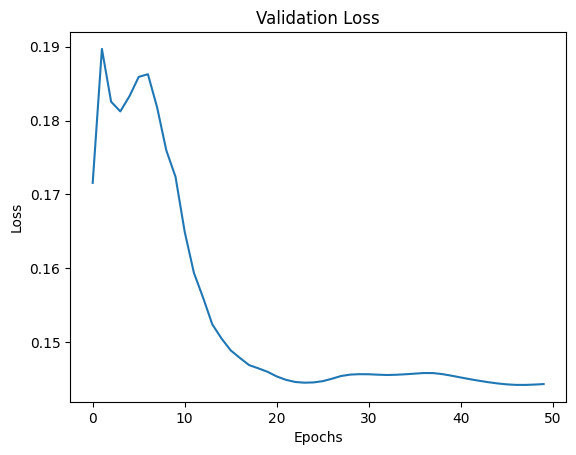

In [113]:
train_model(model, optimizer, criterion, train_loader, valid_loader, 50)

In [114]:
best_model =  GRUNet(input_size=input_GRU, hidden_size=hidden_size, num_layers=layers, output_size=output_GRU)
best_model.load_state_dict(torch.load('best_model_GRU.pth'.format(input)))
predictions_n_to_n, actuals_n_to_n = test_model(best_model, test_loader, criterion)

Test Loss: 0.1722


In [115]:
result_prediction(predictions_n_to_n, actuals_n_to_n)

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Global,,,,,,
Global,+,0.19755,0.414853,ERROR,5.657105,5.171471


In [116]:
results_month = result_prediction_by_month(predictions_n_to_n, actuals_n_to_n)
results_month

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Month,,,,,,
January,+,0.164161,0.371136,ERROR,4.057103,3.854620
February,+,0.159525,0.365015,ERROR,4.777597,4.415136
March,+,0.227947,0.439561,ERROR,6.124865,5.672352
April,+,0.216654,0.425448,ERROR,6.654594,6.030581
May,+,0.186367,0.392159,ERROR,5.804953,5.280527
June,+,0.210935,0.458067,ERROR,6.839496,6.122885
July,+,0.210884,0.430322,ERROR,4.889352,4.507516
August,+,0.200970,0.424743,ERROR,6.082005,5.462371


In [117]:
results_week = result_prediction_by_week(predictions_n_to_n, actuals_n_to_n)
results_week

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Week,,,,,,
00,+,0.092077,0.172872,ERROR,1.301506,1.304287
01,+,0.154262,0.310974,ERROR,4.573096,4.247137
02,+,0.167788,0.392321,ERROR,4.401632,4.104537
03,+,0.171135,0.415222,ERROR,3.406809,3.389046
04,+,0.189679,0.408520,ERROR,4.829400,4.587645
05,+,0.145303,0.352363,ERROR,3.576960,3.443691
06,+,0.180318,0.435769,ERROR,5.476672,5.000687
07,+,0.167804,0.344550,ERROR,4.915066,4.572329
08,+,0.147086,0.315861,ERROR,5.283948,4.789660


In [118]:
results_day = result_prediction_by_day(predictions_n_to_n, actuals_n_to_n)
results_day.sort_values(["SMAPE"], ascending=False)

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Day,,,,,,
223,+,0.273716,0.570144,ERROR,28.216944,23.213089
99,+,0.321403,0.557845,ERROR,19.179605,16.287234
232,+,0.213759,0.406097,ERROR,18.322322,15.278666
92,+,0.232921,0.448364,ERROR,17.717976,14.708087
167,+,0.181947,0.499686,ERROR,17.707789,14.777320
...,...,...,...,...,...,...
3,+,0.084301,0.164492,ERROR,1.095747,1.104998
2,+,0.085319,0.174766,ERROR,1.000618,0.999513
10,+,0.075530,0.123654,0.981283,0.981532,0.980780


In [119]:
results_hour = result_prediction_by_hour(predictions_n_to_n, actuals_n_to_n)
results_hour.sort_values(["SMAPE"], ascending=False)

,Signe error,MAE,RMSE,MAPE,SMAPE,MAAPE
Day / Hour,,,,,,
92 / 18,+,0.318485,0.378694,ERROR,191.733884,148.906394
99 / 10,-,0.617441,1.323135,ERROR,188.363797,141.992389
223 / 5,+,0.244269,0.277069,ERROR,187.380549,148.737727
167 / 18,-,0.350497,0.503202,ERROR,182.322994,139.129104
166 / 18,+,0.328363,0.402307,ERROR,174.112031,140.788463
...,...,...,...,...,...,...
21 / 3,+,0.000422,0.000422,0.003833,0.003833,0.003833
209 / 11,+,0.000422,0.000422,0.003833,0.003833,0.003833
193 / 4,+,0.000422,0.000422,0.003833,0.003833,0.003833
